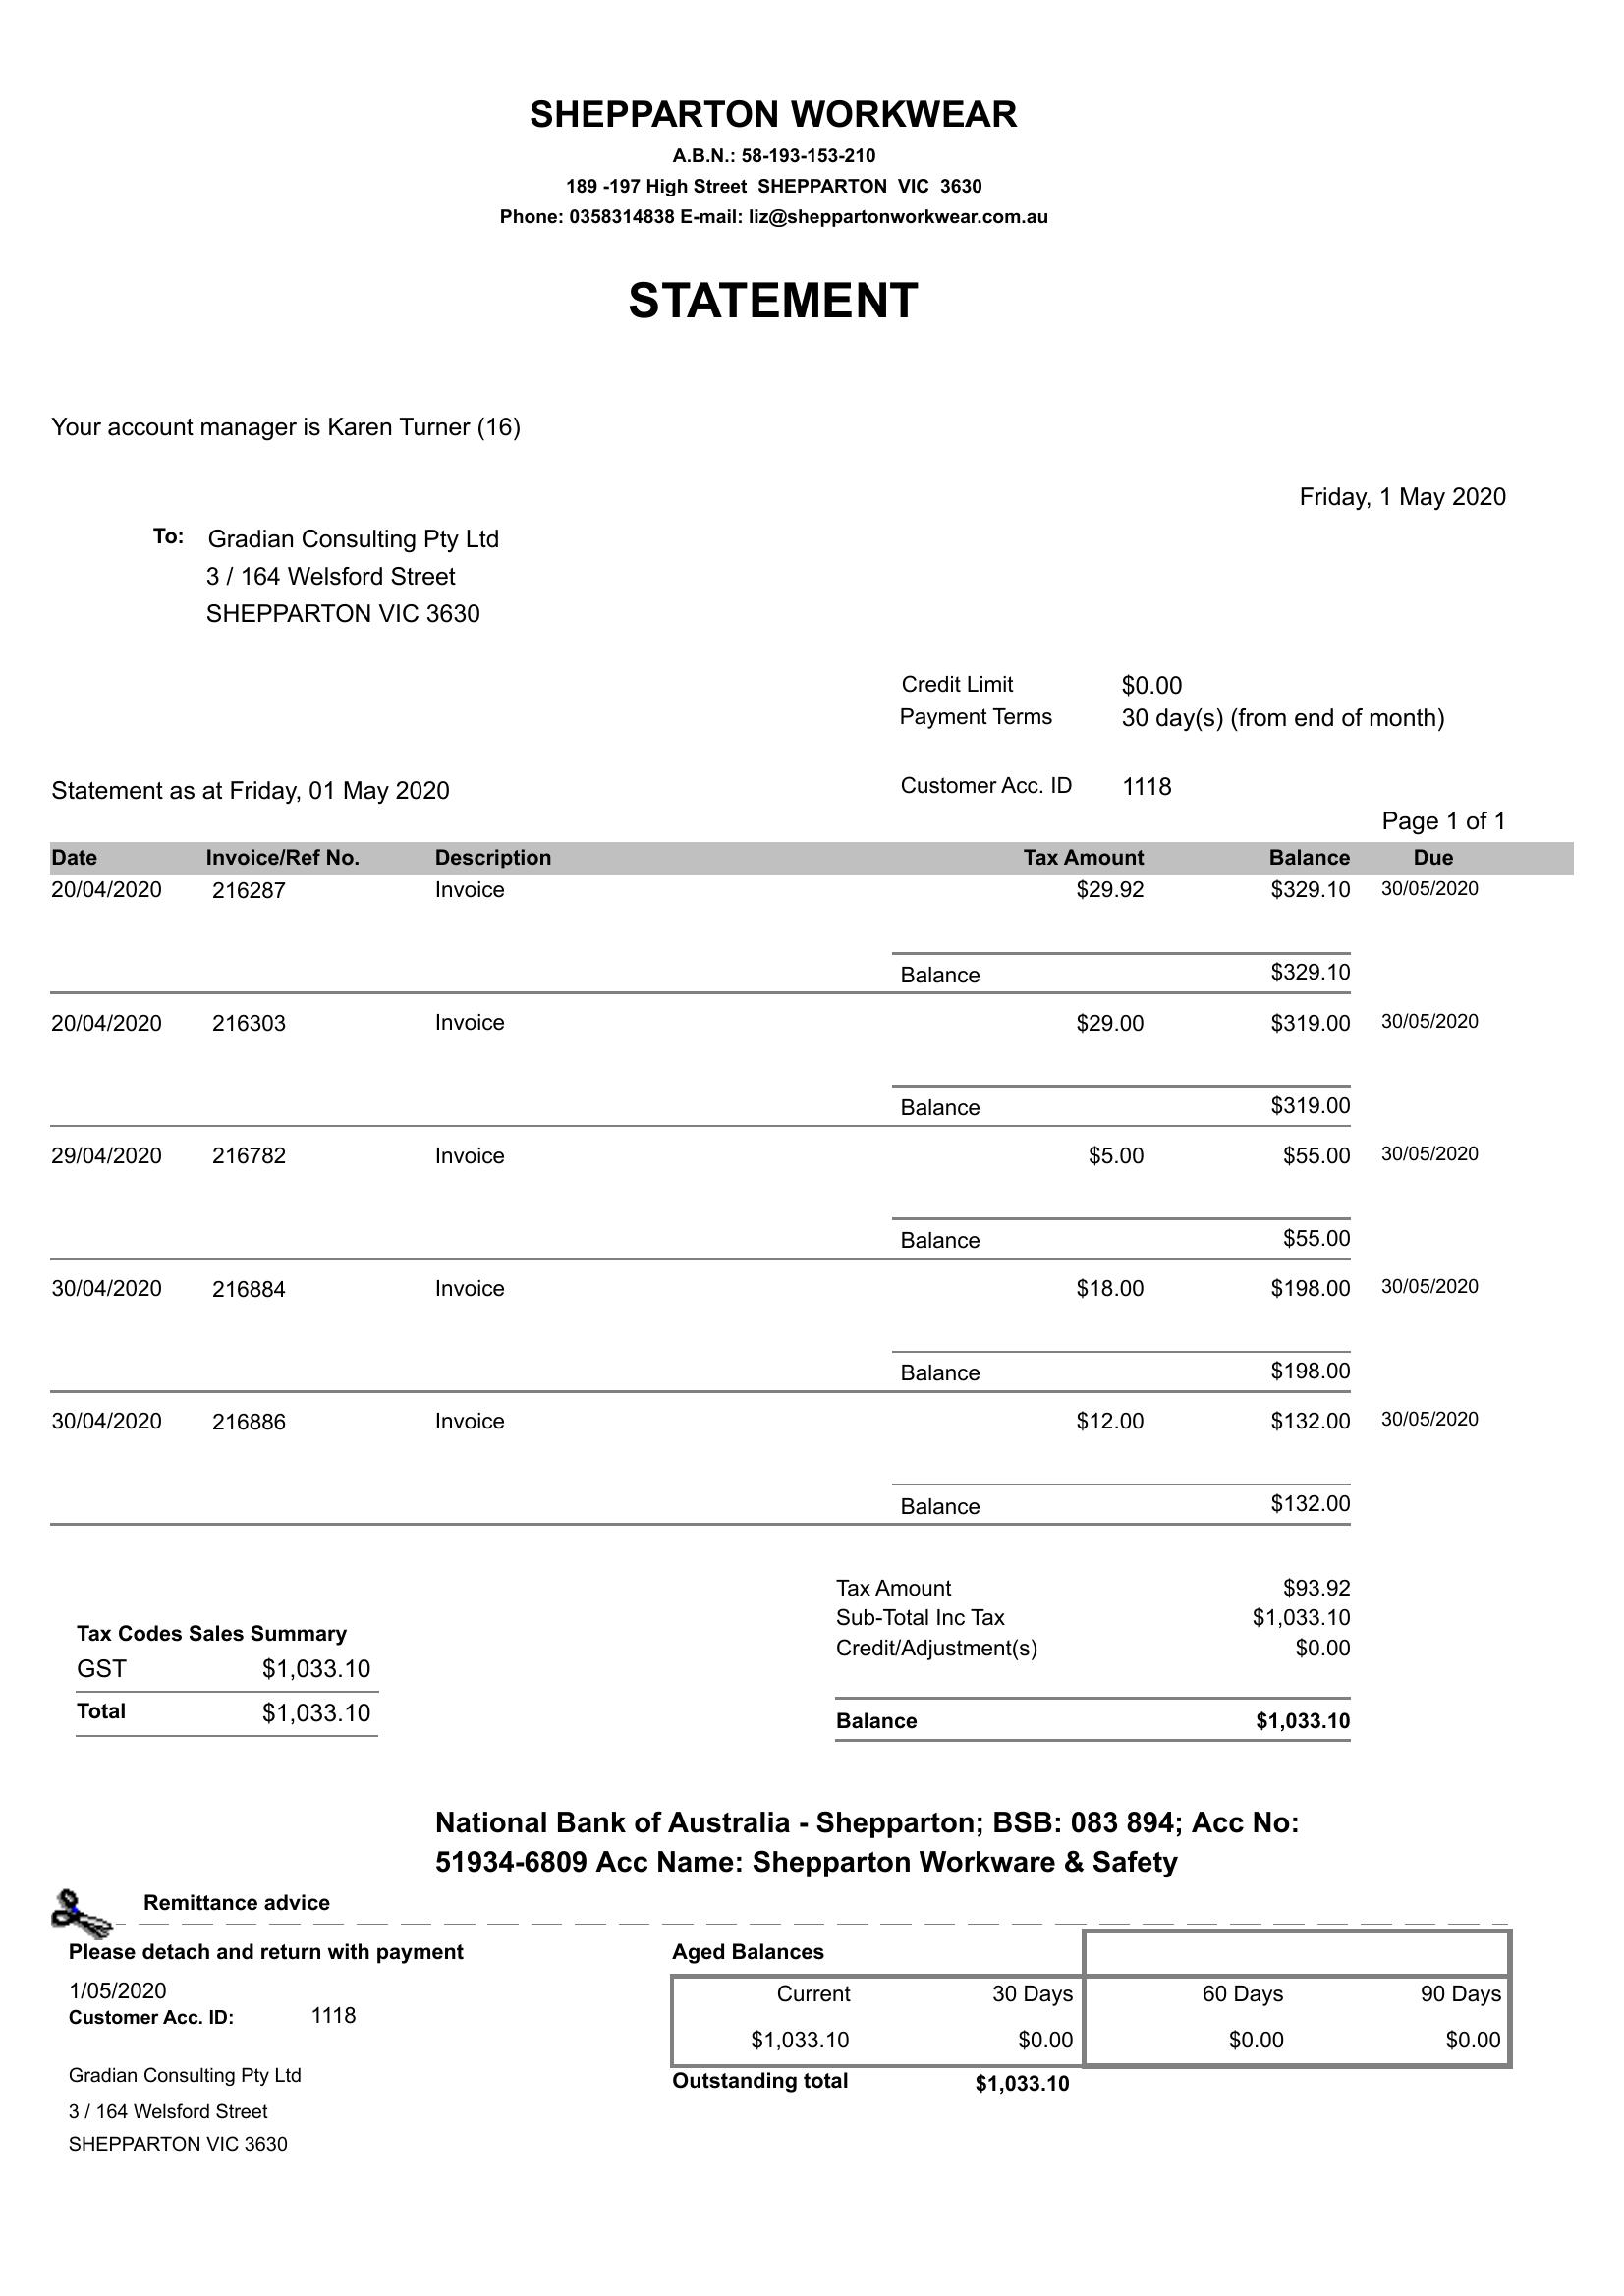

In [2]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("docs_data/invoice/p_1.jpg")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [3]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'SHEPPARTON WORKWEAR A.B.N.: 58-193-153-210 189 -197 High Street SHEPPARTON VIC 3630 Phone: 0358314838 E-mail: liz@sheppartonworkwear.com.au STATEMENT Your account manager is Karen Turner (16) Friday, 1 May 2020 To:  Gradian Consulting Pty Ltd 3 /164 Welsford Street SHEPPARTON VIC 3630 Credit Limit $0.00 Payment Terms 30 day(s) (from end of month) Statement as at Friday, 01 May 2020 Customer Acc. ID 1118 Page 1 of 1 Date Invoice/Ref No. Description Tax Amount Balance Due 20/04/2020 216287 Invoice $29.92 $329.10  30/05/2020 Balance $329.10 20/04/2020 216303 Invoice $29.00 $319.00  30/05/2020 Balance $319.00 29/04/2020 216782 Invoice $5.00 $55.00  30/05/2020 Balance $55.00 30/04/2020 216884 Invoice $18.00 $198.00  30/05/2020 Balance $198.00 30/04/2020 216886 Invoice $12.00 $132.00 30/05/2020 Balance $132.00 Tax Amount $93.92 Sub-Total Inc Tax $1,033.10 Tax Codes Sales Summary Credit/Adjustment(s) $0.00 GST $1,033.10 Total $1,033.10 Balance $1,033.10 National Bank of Australia - Shepparto

We can also visualize the bounding boxes of the recognized words, as follows:

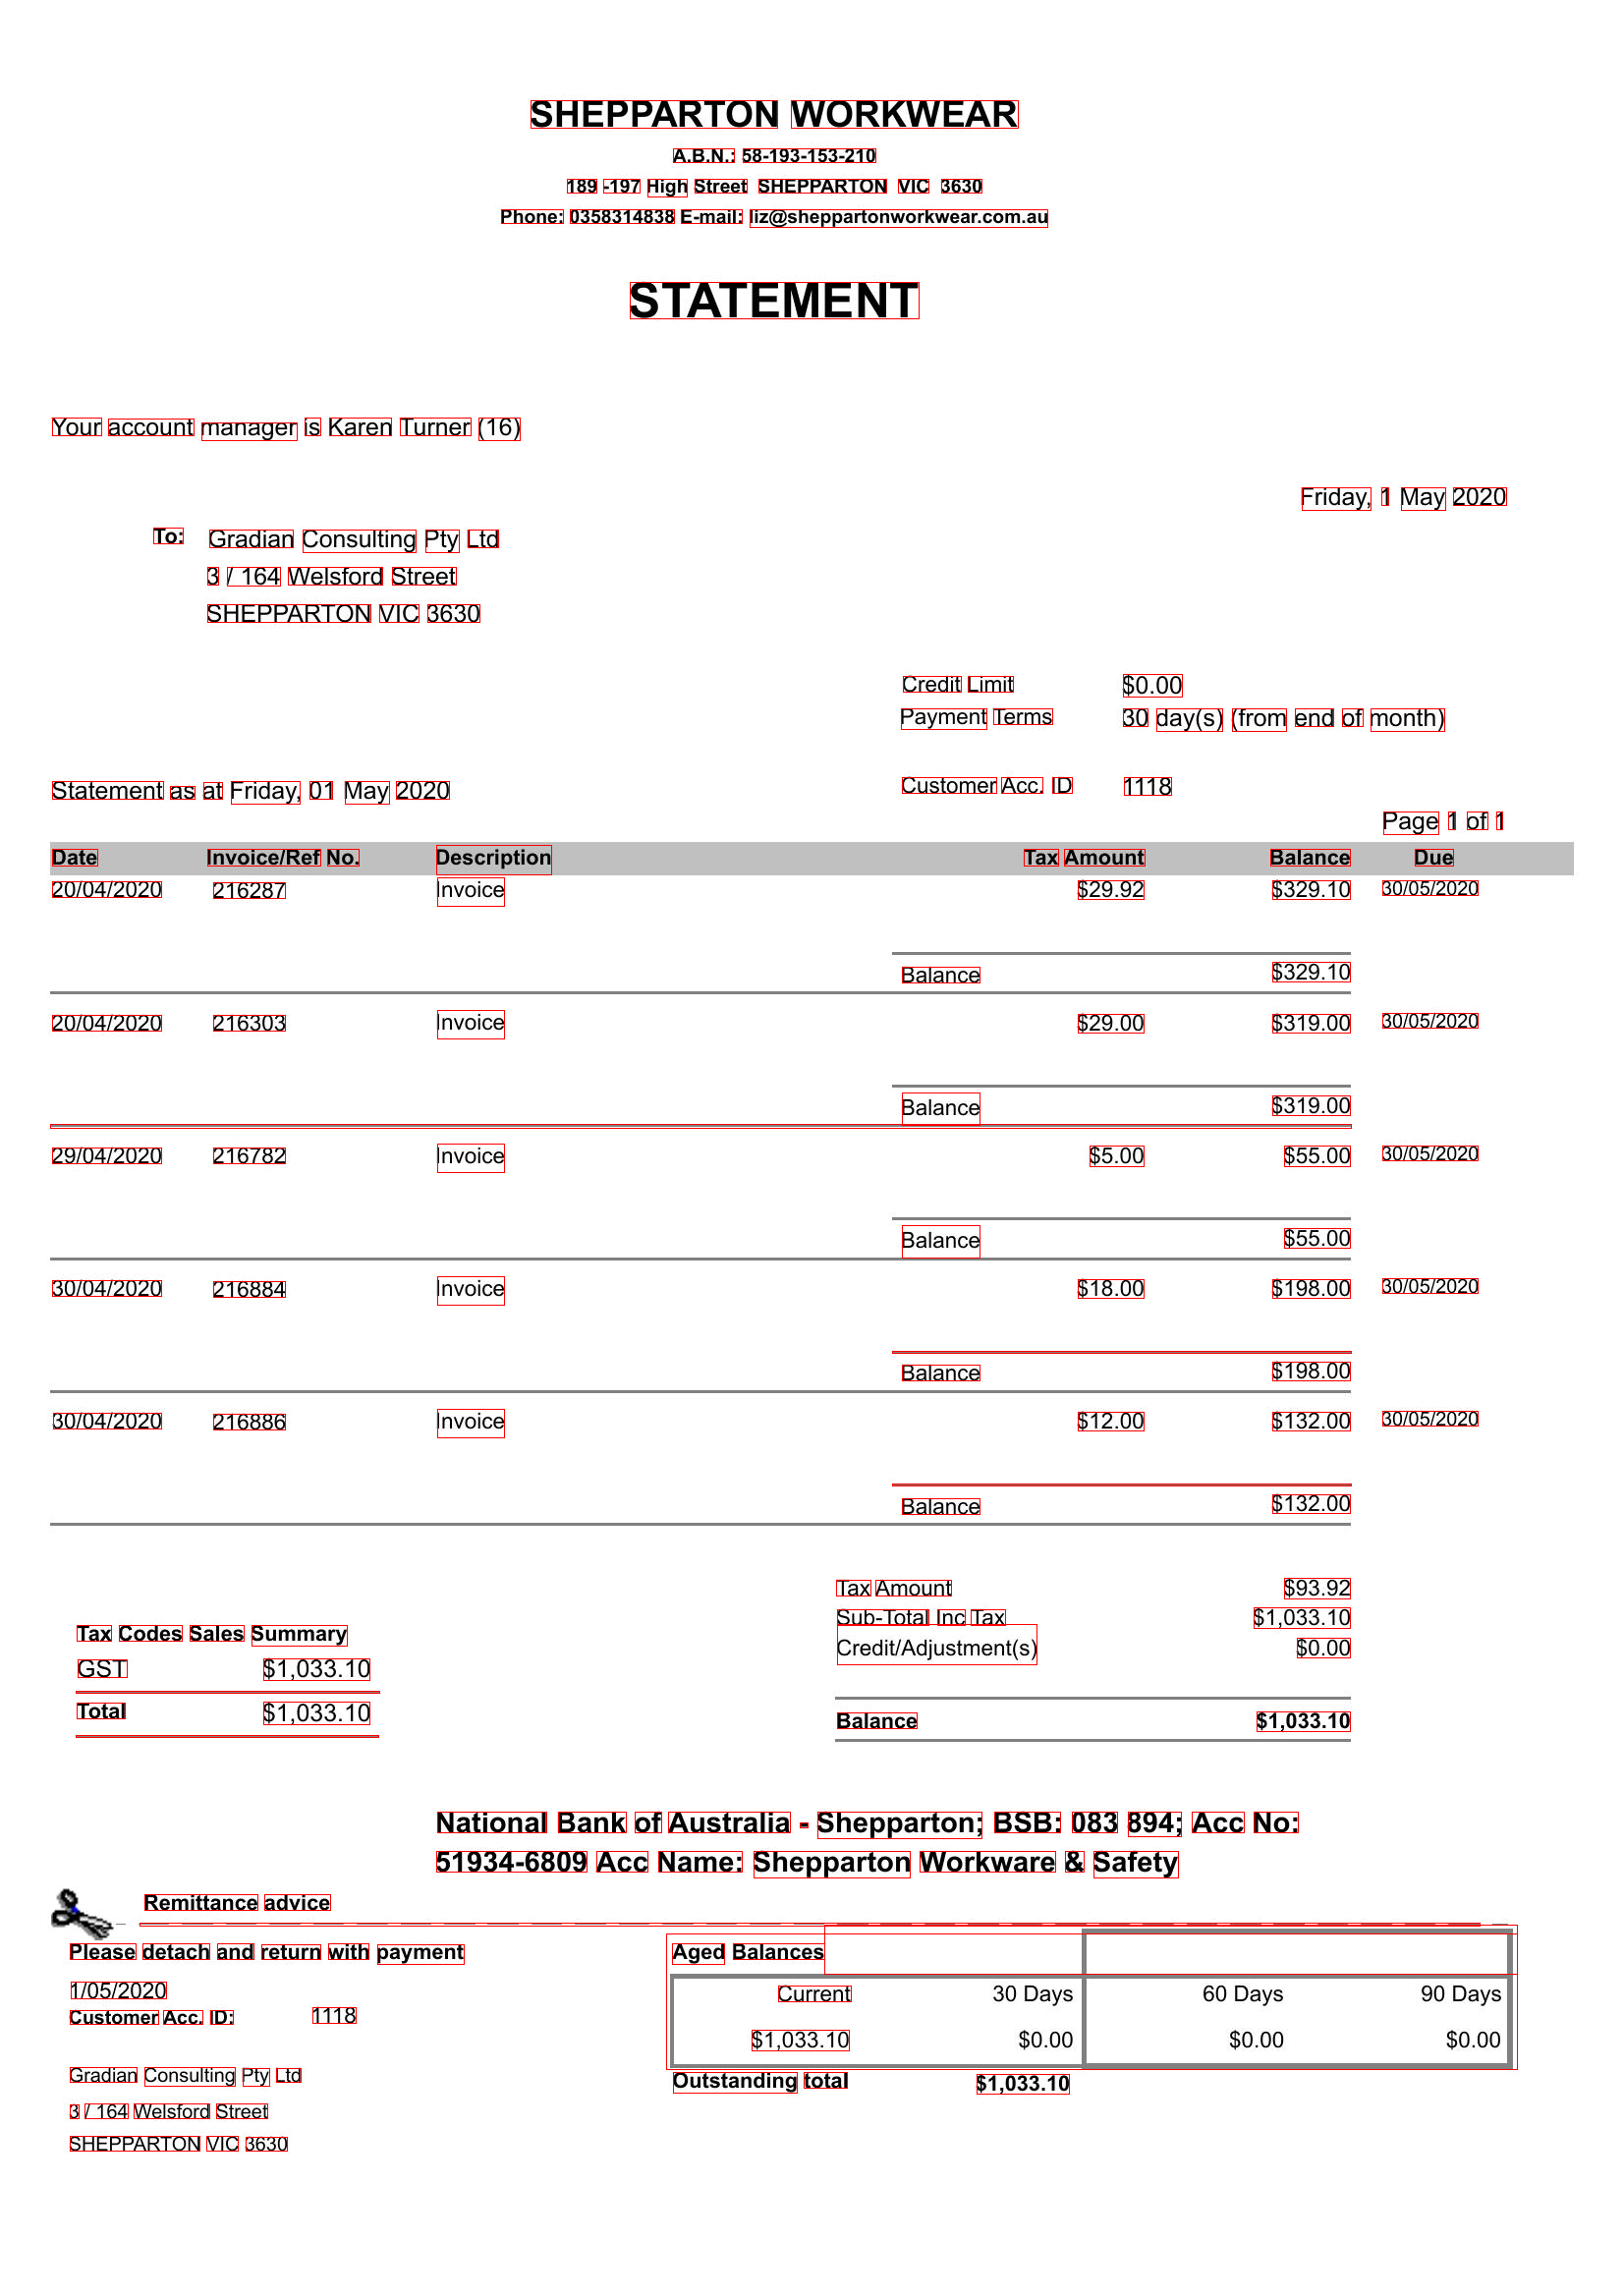

In [4]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: `image_path` and `label`.

In [5]:
import pandas as pd
import os

dataset_path = "docs_data"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'bill': 0, 'invoice': 1, 'others': 2, 'Purchase_Order': 3, 'remittance': 4}

In [6]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[10:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,docs_data/bill/p_10.jpg,bill
1,docs_data/bill/p_11.jpg,bill
2,docs_data/bill/p_117.jpg,bill
3,docs_data/bill/p_12.jpg,bill
4,docs_data/bill/p_132.jpg,bill


In [7]:
len(data)

449

Now, let's apply OCR to get the words and bounding boxes of every image. To do this efficiently, we turn our Pandas dataframe into a HuggingFace `Dataset` object, and use the `.map()` functionality to get the words and normalized bounding boxes of every image. Note that this can take a while to run (Tesseract seems a bit slow).

In [8]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

dataset = Dataset.from_pandas(data)
updated_dataset = dataset.map(apply_ocr)

  0%|          | 0/449 [00:00<?, ?ex/s]

In [9]:
updated_dataset

Dataset({
    features: ['bbox', 'image_path', 'label', 'words'],
    num_rows: 449
})

In [10]:
import pandas as pd
df = pd.DataFrame.from_dict(updated_dataset)
print(len(df["words"][0]))
print(df["words"][0])

206
['Sales', 'Order', 'Acknowledgement', 'iplex', 'We', 'ko', 'Wader', 'ABN:', '56', '079', '613', '308', 'IPLEX', 'PIPELINES', 'AUSTRALIA', 'PTY', 'LTD', 'PO', 'BOX', '5160', 'SEND', 'TO:', 'SHIP', 'TO:', 'BRENDALE', '‘%6%', 'GRADIAN', 'PROJECTS', 'PTY', 'LTD', 'GV', 'WATER/HARRIS', 'PLUMBING', 'AND', 'WELDING', '213', 'HIGH', 'STREET', '6-34', 'COOMBS', 'ROAD', 'Phone:', '131', '086', 'SHEPPARTON', 'vic', '07:00-16:00', 'XAVIER', 'HARRIS', 'PH:0488727144', 'Fax:', '131860', '3630', 'TATURA', 'vIC', '3616', 'Date', 'Printed', 'Sales', 'Order', 'No.', 'Customer', 'Order', 'No.', 'Customer', 'No.', 'Shipment', 'No.', 'p', 'o', '29/01/21', '2593929', 'SO', 'PO-0029', '2495012', 'ags', '%', 'd', 'Product', 'et', '.', 'Unit', 'Price', 'Extended', 'Price', '|', 'Tax', 'Customer', 'Item', 'No.|', 'Description', 'Quantity', '(UOM', '|Backorder', 'Q', 'UoM', '-', 'Code', 'P', 'v', 'Y|', '(excl.', 'GST)', '(excl.', 'GST)', '|(y/n)', 'POH12140M', '140', 'SDR13.6', 'POLY', 'PE100', 'PIPE', 'LE',

Next, we can turn the word-level 'words' and 'bbox' columns into token-level `input_ids`, `attention_mask`, `bbox` and `token_type_ids` using `LayoutLMTokenizer`.

In [11]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding

In [13]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D
# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

encoded_dataset = updated_dataset.map(lambda example: encode_example(example), 
                                      features=features)

  0%|          | 0/449 [00:00<?, ?ex/s]

Finally, we set the format to PyTorch, as the LayoutLM implementation in the Transformers library is in PyTorch. We also specify which columns we are going to use.

In [14]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [15]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))

Let's verify whether the input ids are created correctly by decoding them back to text:

In [27]:
tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] renting a home : a guide for tenants completing the ‘ condition report ’ it is important to note on the ‘ condition report ’ if you disagree with any points. check that everything attached to a ceiling, wall or a door ( for example, light fittings, mantelpieces, hooks and handles ) is fixed securely and unlikely to injure anyone. take photographs, particularly of any features of the premises you have made a note of in the condition report. reporting safety issues you should inform your landlord or agent of any defects that pose a threat to safety so these can be fixed by an expert. if you report a safety risk and it is not fixed, you can take further action > see ‘ repairs ’ on page 25. if the problem is serious enough to make the premises unsafe to live in, notify your landlord or agent immediately. if the problem cannot be fixed, you may be able to end your tenancy agreement. for more information > see ‘ when you want to ‘ on page 40. 18 water meter readings if the property ha

In [29]:
idx2label[batch['label'][0].item()]

'others'

## Define the model

Here we define the model, namely `LayoutLMForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.



In [31]:
from transformers import LayoutLMForSequenceClassification
import torch
from transformers import logging

logging.set_verbosity_warning()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
      

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see [here](https://github.com/microsoft/unilm/blob/5d16c846bec56b6e88ec7de4fc3ceb7c803571a4/layoutlm/examples/classification/run_classification.py#L94) for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [32]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=4e-5)

global_step = 0
num_train_epochs = 30
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0
Loss: 272.3193453811109
Training accuracy: 82.18263244628906
Epoch: 1
Loss: 137.21977971307933
Training accuracy: 90.42316436767578
Epoch: 2
Loss: 99.36077739321627
Training accuracy: 93.76392364501953
Epoch: 3
Loss: 63.66303726891056
Training accuracy: 96.65924835205078
Epoch: 4
Loss: 116.21778080007061
Training accuracy: 91.53675079345703
Epoch: 5
Loss: 178.8727256145794
Training accuracy: 87.08240509033203
Epoch: 6
Loss: 153.52557719312608
Training accuracy: 89.53229522705078
Epoch: 7
Loss: 91.72779256850481
Training accuracy: 94.87751007080078
Epoch: 8
Loss: 32.3703742736252
Training accuracy: 98.21826934814453
Epoch: 9
Loss: 13.089436096837744
Training accuracy: 99.33184814453125
Epoch: 10
Loss: 25.43767284770729
Training accuracy: 98.21826934814453
Epoch: 11
Loss: 1.7640218239394017
Training accuracy: 100.0
Epoch: 12
Loss: 16.75555340491701
Training accuracy: 99.109130859375
Epoch: 13
Loss: 48.644877631100826
Training accuracy: 97.77283477783203
Epoch: 14
Loss: 1.0153465

# Inference

#### NOTE: Check Predictor notebook for Inference from the Saved Model

In [ ]:
# from transformers import LayoutLMTokenizer, LayoutLMForSequenceClassification
# import torch
# tokenizer = LayoutLMTokenizer.from_pretrained('microsoft/layoutlm-base-uncased')
# model = LayoutLMForSequenceClassification.from_pretrained('microsoft/layoutlm-base-uncased')
# words = ["Hello", "world"]
# normalized_word_boxes = [637, 773, 693, 782], [698, 773, 733, 782]
# token_boxes = []
# for word, box in zip(words, normalized_word_boxes):
#     word_tokens = tokenizer.tokenize(word)
#     token_boxes.extend([box] * len(word_tokens))
# # add bounding boxes of cls + sep tokens
# token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
# encoding = tokenizer(' '.join(words), return_tensors="pt")
# input_ids = encoding["input_ids"]
# attention_mask = encoding["attention_mask"]
# token_type_ids = encoding["token_type_ids"]
# bbox = torch.tensor([token_boxes])
# sequence_label = torch.tensor([1])
# outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
#                 labels=sequence_label)
# loss = outputs.loss
# logits = outputs.logits

# Saving the model

In [33]:
model.save_pretrained('saved_model/')